In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Trial 10 Complete [00h 08m 27s]
val_mae: 31.437536239624023

Best val_mae So Far: 26.316696166992188
Total elapsed time: 01h 23m 48s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1325/1325 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

=== Stacked LSTM Test Evaluation ===
MAE   : 25.99
RMSE  : 54.60
sMAPE : 5.09%
R²    : 0.974


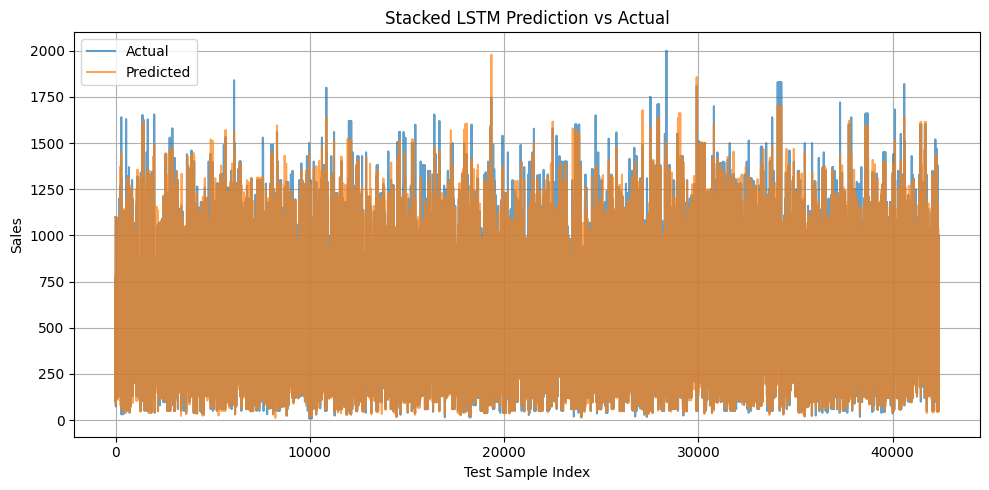

In [ ]:
# === Install Dependencies ===
!pip install -q keras-tuner scikit-learn

# === Imports ===
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import keras_tuner as kt
import matplotlib.pyplot as plt

# === Load and Prepare Dataset ===
file_path = "/content/drive/MyDrive/MRP/Current/Deliverables/Methodology_&_Experiments/Report/Coding/Data_files/Final_Selected_Features_new.csv"
df = pd.read_csv(file_path, parse_dates=["date_only"])
df = df.sort_values("date_only")

# === Feature/Target Split ===
target = "Sales"
X = df.drop(columns=["Sales", "date_only"]).select_dtypes(include=[np.number])
y = df[target]

# === Handle NaN values in features ===
X = X.fillna(method='ffill').fillna(method='bfill')


# === Standardize Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Reshape for LSTM (samples, time_steps=1, features) ===
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, shuffle=False)

# === Stacked LSTM Model Builder ===
def build_stacked_lstm(hp):
    model = keras.Sequential()

    # First LSTM layer with return_sequences=True
    model.add(layers.LSTM(
        units=hp.Int("lstm_units_1", 32, 128, step=32),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))

    # Second LSTM layer
    model.add(layers.LSTM(
        units=hp.Int("lstm_units_2", 32, 128, step=32),
        return_sequences=False
    ))

    # Dropout
    model.add(layers.Dropout(hp.Float("dropout_rate", 0.0, 0.5, step=0.1)))

    # Dense layer
    model.add(layers.Dense(
        units=hp.Int("dense_units", 32, 128, step=32),
        activation="relu"
    ))

    # Output
    model.add(layers.Dense(1))

    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )
    return model

# === Tuner Setup ===
tuner = kt.RandomSearch(
    build_stacked_lstm,
    objective="val_mae",
    max_trials=10,
    executions_per_trial=1,
    directory="stacked_lstm_tuning",
    project_name="mrp_stacked_lstm"
)

# === Run Tuning ===
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)

# === Get Best Model ===
best_model = tuner.get_best_models(1)[0]

# === Evaluate on Test ===
y_pred = best_model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    return np.mean(np.where(denominator == 0, 0, diff / denominator)) * 100

s_mape = smape(y_test.values, y_pred)
r2 = r2_score(y_test, y_pred)

# === Print Metrics ===
print("\n=== Stacked LSTM Test Evaluation ===")
print(f"MAE   : {mae:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"sMAPE : {s_mape:.2f}%")
print(f"R²    : {r2:.3f}")

# === Plot ===
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.title("Stacked LSTM Prediction vs Actual")
plt.xlabel("Test Sample Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MRP/Current/Deliverables/Methodology_&_Experiments/Report/Coding/Data_files/Plots/stacked_lstm_prediction_vs_actual.png")
plt.show()